<a href="https://colab.research.google.com/github/AmitHaim1/stix-shifter/blob/splunk_ext/Carmon2019Unlabeled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install geotorch
!pip install torchdiffeq

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-th2fgqzu
  Running command git clone -q https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-th2fgqzu
  Cloning https://github.com/fra31/auto-attack.git (to revision 6482e4d6fbeeb51ae9585c41b16d50d14576aadc) to /tmp/pip-install-3x2j7q7h/autoattack_47655db6f214485d977ad566d2eec73a
  Running command git clone -q https://github.com/fra31/auto-attack.git /tmp/pip-install-3x2j7q7h/autoattack_47655db6f214485d977ad566d2eec73a
  Running command git rev-parse -q --verify 'sha^6482e4d6fbeeb51ae9585c41b16d50d14576aadc'
  Running command git fetch -q https://github.com/fra31/auto-attack.git 6482e4d6fbeeb51ae9585c41b16d50d14576aadc
  Running command git checkout -q 6482e4d6fbeeb51ae9585c41b16d50d14576aadc
     |████████████████████████████████| 61 kB 3.4 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 9.9 MB 40.3 MB/s 
  Created wheel for robustbench: fil

     |████████████████████████████████| 54 kB 2.0 MB/s 


**CIFAR-10
Linf, eps=8/255**

In [2]:
from robustbench.utils import load_model
from robustbench.data import load_cifar10

x_test, y_test = load_cifar10(n_examples=50)

x_test = x_test.cuda()
y_test = y_test.cuda()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


*Load* Standard model

In [3]:
# WideResNet-28-10 Architecture
standard_model = load_model(model_name='Standard', dataset='cifar10', threat_model='Linf')

Download started: path=models/cifar10/Linf/Standard.pt (gdrive_id=1t98aEuzeTL8P7Kpd5DIrCoCL21BNZUhC)
Download finished: path=models/cifar10/Linf/Standard.pt (gdrive_id=1t98aEuzeTL8P7Kpd5DIrCoCL21BNZUhC)


Load Robust model

Unlabeled Data Improves Adversarial Robustness
[link](https://arxiv.org/abs/1905.13736)

In [4]:
# WideResNet-28-10 Architecture
# clean accuracy: 89.69%, robust accuracy:	59.53%.    	
robust_model = load_model(model_name='Carmon2019Unlabeled', dataset='cifar10', threat_model='Linf')

Download started: path=models/cifar10/Linf/Carmon2019Unlabeled.pt (gdrive_id=15tUx-gkZMYx7BfEOw1GY5OKC-jECIsPQ)
Download finished: path=models/cifar10/Linf/Carmon2019Unlabeled.pt (gdrive_id=15tUx-gkZMYx7BfEOw1GY5OKC-jECIsPQ)


## *robustness evaluation*

Foolbox Native: Fast adversarial attacks to benchmark the robustness of machine learning models in PyTorch, TensorFlow, and JAX

In [5]:
!pip install -q foolbox

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 43.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [6]:
import foolbox as fb

standard_model_fb = fb.PyTorchModel(standard_model, bounds=(0, 1))
robust_model_fb = fb.PyTorchModel(robust_model, bounds=(0, 1))

Accuracy

In [7]:
fb.utils.accuracy(standard_model_fb, x_test, y_test), fb.utils.accuracy(robust_model_fb, x_test, y_test)

(0.9599999785423279, 0.9199999570846558)

*Attack models for messure robustness*

In [8]:
attack = fb.attacks.LinfDeepFoolAttack()
_, r_model_advs, r_model_success = fb.attacks.LinfPGD(rel_stepsize=0.1, steps=20)(robust_model_fb, x_test, y_test, epsilons=[8/255])
_, s_model_advs, s_model_success = fb.attacks.LinfPGD(rel_stepsize=0.1, steps=20)(standard_model_fb, x_test, y_test, epsilons=[8/255])



In [9]:
print('Robust accuracy for rubust model: {:.1%}'.format(1 - r_model_success.float().mean()))
print('Robust accuracy for standard model: {:.1%}'.format(1 - s_model_success.float().mean()))

Robust accuracy for rubust model: 58.0%
Robust accuracy for standard model: 0.0%


In [10]:
_, r_model_advs, r_model_success = fb.attacks.LinfBasicIterativeAttack(rel_stepsize=0.1, steps=20)(robust_model_fb, x_test, y_test, epsilons=[8/255])
_, s_model_advs, s_model_success = fb.attacks.LinfBasicIterativeAttack(rel_stepsize=0.1, steps=20)(standard_model_fb, x_test, y_test, epsilons=[8/255])


In [11]:
print('Robust accuracy for rubust model: {:.1%}'.format(1 - r_model_success.float().mean()))
print('Robust accuracy for standard model: {:.1%}'.format(1 - s_model_success.float().mean()))

Robust accuracy for rubust model: 58.0%
Robust accuracy for standard model: 0.0%


# Activation of explanation methods - Local Interpretability

## **shap**

In [12]:
!pip install shap

     |████████████████████████████████| 564 kB 5.5 MB/s 


In [39]:
import shap
import numpy as np

def get_shap_values(model, test):
  # explain predictions of the model on test group images
  e = shap.DeepExplainer(model, test)
  # take shap values of the following images
  return e.shap_values(test)  

def plot_images(shap_values, test):
  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  test_numpy = np.swapaxes(np.swapaxes(test.cpu().numpy(), 1, -1), 1, 2)
  ## check if we need to pass before a bigger amount of images, and then cut few??
  shap.image_plot(shap_numpy, test_numpy[:5])

tensor(3, device='cuda:0')


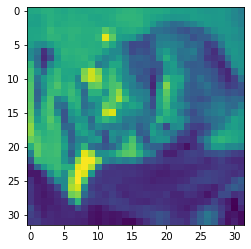

tensor(8, device='cuda:0')


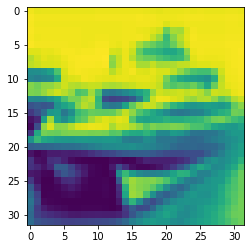

tensor(8, device='cuda:0')


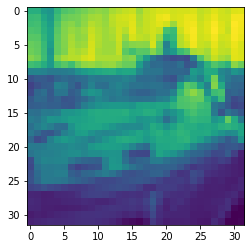

tensor(0, device='cuda:0')


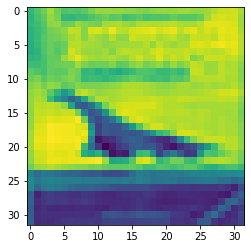

tensor(6, device='cuda:0')


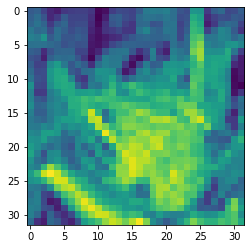

In [14]:
import matplotlib.pyplot as plt

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for tup in zip(x_test[:5], y_test[:5]):
  print(tup[1])
  plt.imshow(tup[0].cpu().numpy()[0])
  plt.show()

*standard model* - 

calculation of shap values and ploting

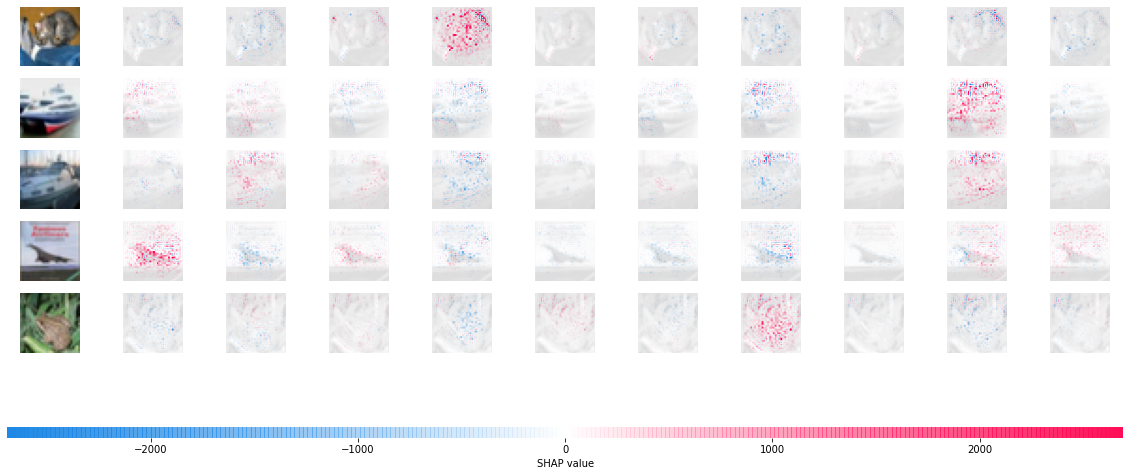

In [40]:
background = x_test[:10]
shap_values = get_shap_values(standard_model, background)
plot_images(shap_values, x_test[:5])

*robust model* - 

calculation of shap values and ploting

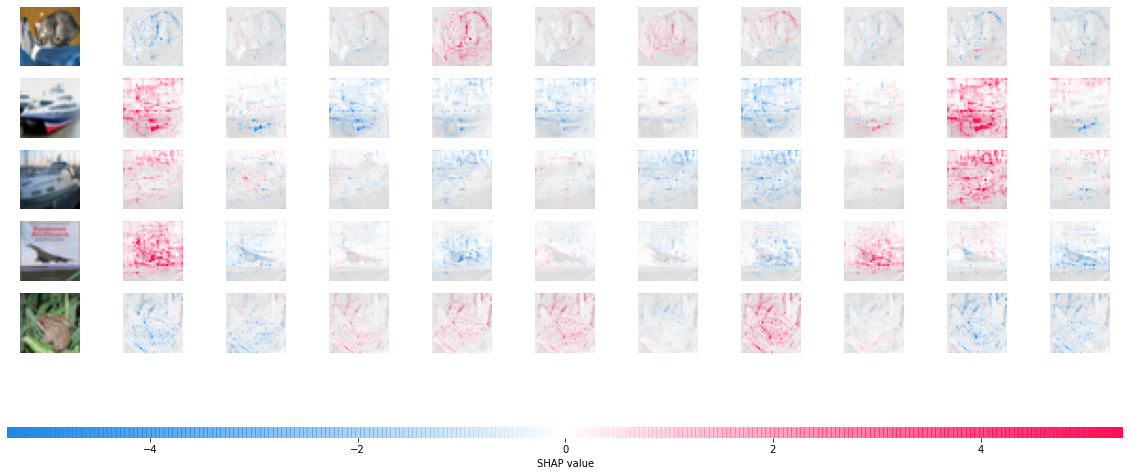

In [41]:
background = x_test[:10]
shap_values = get_shap_values(robust_model.cuda(), background.cuda())
plot_images(shap_values, x_test[:5])

# Captum 

In [17]:
!pip install captum

     |████████████████████████████████| 1.4 MB 5.5 MB/s 


In [18]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [19]:
device = torch.device('cuda')

#### *Load test dataset, define image transformers and supported classification label classes.*



In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### *Load some images from the test dataset and perform predictions.*



In [21]:
import torch.nn as nn
import torch.nn.functional as F

def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

##### *standard model predictions:*

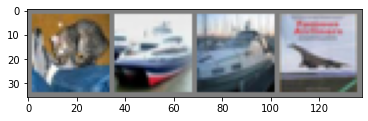

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane


In [22]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

standard_model.cuda()
s_outputs = standard_model(images.cuda())

_, s_predicted = torch.max(s_outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[s_predicted[j]]
                              for j in range(4)))

##### *robust model predictions:*

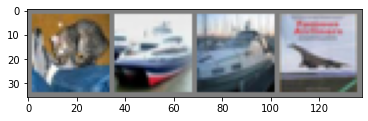

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane


In [23]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

robust_model.cuda()
r_outputs = robust_model(images.cuda())

_, r_predicted = torch.max(r_outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[r_predicted[j]]
                              for j in range(4)))

Let's choose a test image at index ind and apply some of our attribution algorithms on it, and Sets model to eval mode for interpretation purposes





In [24]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True
input = input.cuda()


'''
model.eval() is a kind of switch for some specific layers/parts of the model
 that behave differently during training and inference (evaluating) time.
 For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off 
 them during model evaluation, and .eval() will do it for you.
'''
standard_model.eval()
robust_model.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [25]:
def attribute_image_features(model, algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

#Computes gradients with respect to class ind and transposes them for visualization purposes.


In [35]:
#Computes gradients with respect to class ind and transposes them for visualization purposes.

'''
the simple gradient often exhibits a large degree of visual noise
and does not always correspond to human intuition regarding feature contribution

This has motivated the development of more elaborate salience map generation
 techniques in order to induce more structured and visually meaningful interpretations.
'''
def get_grads(model, input):
  model = model.to(device)
  input = input.to(device)
  saliency = Saliency(model)
  grads = saliency.attribute(input, target=labels[ind].item())
  grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
  return grads

#Applies integrated gradients attribution algorithm on test image
def get_integrated_grads(model, input):
  model = model.to(device)
  input = input.to(device)
  ig = IntegratedGradients(model)
  attr_ig, delta = attribute_image_features(model, ig, input, baselines=input * 0, return_convergence_delta=True)
  attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
  print('Approximation delta: ', abs(delta))
  return attr_ig

#integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with smoothgrad square option adds gaussian noise with a standard deviation of stdevs=0.2 to the input image nt_samples times,
#computes the attributions for nt_samples images and returns the mean of the squared attributions across nt_samples images.
def get_integrated_grads_with_noise(model, input):
  model = model.to(device)
  input = input.to(device)
  ig = IntegratedGradients(model)
  nt = NoiseTunnel(ig)
  attr_ig_nt = attribute_image_features(model, nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
  attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
  return attr_ig_nt

def get_DeepLift(model, input):
  model = model.to(device)
  input = input.to(device)
  dl = DeepLift(model)
  attr_dl = attribute_image_features(model, dl, input, baselines=input * 0)
  attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
  return attr_dl

def get_plot(predicted, outputs, grads, attr_ig, attr_dl):
  print('Original Image')
  print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

  original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

  _ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

  _ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

  _ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

  # _ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map",sign="all",
  #                         show_colorbar=True, title="Overlayed Integrated Gradients with noise")  
  _ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="DeepLift")

  


In [37]:
grads = get_grads(standard_model.cuda(), input.cuda())
attr_ig = get_integrated_grads(standard_model, input)
#attr_ig_nt = get_integrated_grads_with_noise(standard_model, input)
attr_dl = get_DeepLift(standard_model, input)

Approximation delta:  tensor([0.3862], device='cuda:0', dtype=torch.float64)


Original Image
Predicted: plane  Probability: 0.9994969367980957


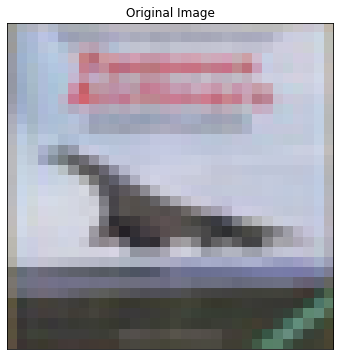

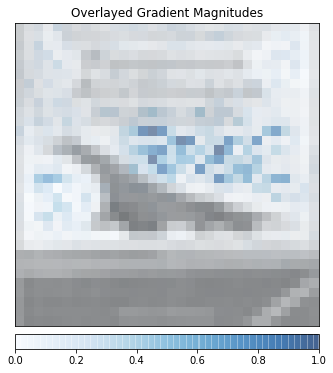

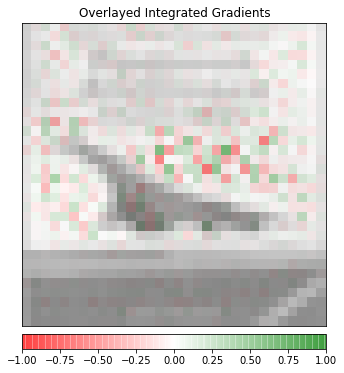

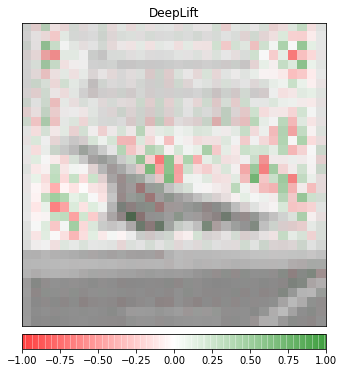

In [28]:
get_plot(s_predicted, s_outputs, grads, attr_ig, attr_dl)

In [38]:
grads = get_grads(robust_model, input)
attr_ig = get_integrated_grads(robust_model, input)
#attr_ig_nt = get_integrated_grads_with_noise(robust_model, input)
attr_dl = get_DeepLift(robust_model, input)

Approximation delta:  tensor([0.0135], device='cuda:0', dtype=torch.float64)


Original Image
Predicted: plane  Probability: 0.792377233505249


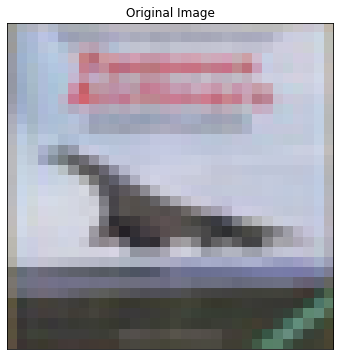

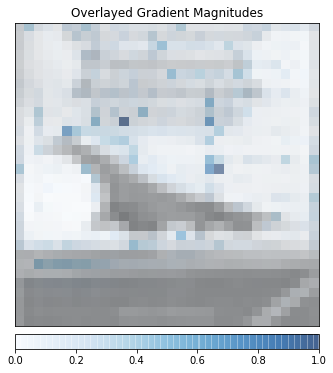

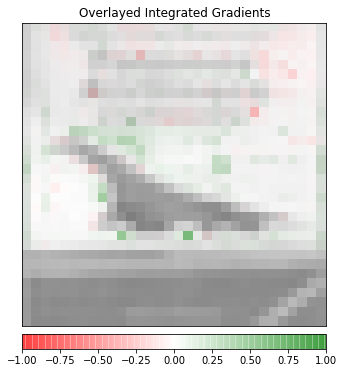

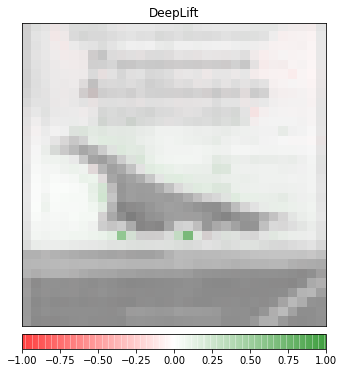

In [30]:
get_plot(r_predicted, r_outputs, grads, attr_ig, attr_dl)